In [1]:
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook
import scipy.io.wavfile as wav
import numpy as np
import theano.tensor as T
import pandas as pd
import theano
%matplotlib inline

In [2]:
!wget http://kibergrad.fm/api/song/download/906394.mp3

--2017-01-05 19:41:25--  http://kibergrad.fm/api/song/download/906394.mp3
Resolving kibergrad.fm (kibergrad.fm)... 104.27.145.185, 104.27.144.185, 2400:cb00:2048:1::681b:90b9, ...
Connecting to kibergrad.fm (kibergrad.fm)|104.27.145.185|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: http://dl.kibergrad.fm/download/906394/Rap+God.mp3.mp3 [following]
--2017-01-05 19:41:25--  http://dl.kibergrad.fm/download/906394/Rap+God.mp3.mp3
Resolving dl.kibergrad.fm (dl.kibergrad.fm)... 104.27.144.185, 104.27.145.185, 2400:cb00:2048:1::681b:90b9, ...
Reusing existing connection to kibergrad.fm:80.
HTTP request sent, awaiting response... 200 OK
Length: 14717632 (14M) [audio/mpeg]
Saving to: ‘906394.mp3’

906394.mp3          100%[===================>]  14.04M   111KB/s    in 2m 10s  

2017-01-05 19:43:35 (111 KB/s) - ‘906394.mp3’ saved [14717632/14717632]



In [3]:
!mpg123 -w out.wav 906394.mp3

High Performance MPEG 1.0/2.0/2.5 Audio Player for Layers 1, 2 and 3
	version 1.22.4; written and copyright by Michael Hipp and others
	free software (LGPL) without any warranty but with best wishes

Playing MPEG stream 1 of 1: 906394.mp3 ...

MPEG 1.0 layer III, 320 kbit/s, 44100 Hz stereo
Title:   Rap God (kibergrad.com)         Artist: Eminem
Comment: (kibergrad.com)                 Album:  The Marshall Mathers LP 2
Year:    2013                            Genre:  Hip-Hop

[6:04] Decoding of 906394.mp3 finished.


In [16]:
data = pd.DataFrame.from_csv("pronuns.csv")

In [17]:
data.pronun_id[1000]

'585fda11698f828c848d8a25'

In [4]:
# Загружаем звук
sampling_rate, sample =  wav.read("out.wav")#"mongodb/sounds/%s.wav" % data.pronun_id[600])

if len(sample.shape) > 1:
    sample = [i[0] for i in sample]
# Длинна окна
sample_count = len(sample)

# Size of window 30ms
window_size_30 = int(30 * (sampling_rate/1000))

In [5]:
# Duration in ms
sample_count/(sampling_rate/1000)

364042.44897959183

In [6]:
# View voice
plt.figure(figsize=(100,7))
plt.plot(sample)

OverflowError: In draw_path: Exceeded cell block limit

In [12]:
def get_energy():
    sample = T.vector(dtype='int64')
    window_size = T.scalar(dtype = 'int16')
    
    sample_sq = sample ** 2
    padded_sample = T.concatenate([T.zeros([window_size]), sample_sq])
    cumsum = T.cumsum(padded_sample)
    energy = cumsum[window_size:] - cumsum[:-window_size]
    
    return theano.function([sample, window_size], energy)

get_energy = get_energy()

In [13]:
energy = get_energy(sample, window_size_30)

Нормализуем

In [10]:
def normalize():
    the_list = T.vector(dtype='float64')
    normalized = the_list / the_list.max()  
    return theano.function([the_list], normalized)

normalize = normalize()

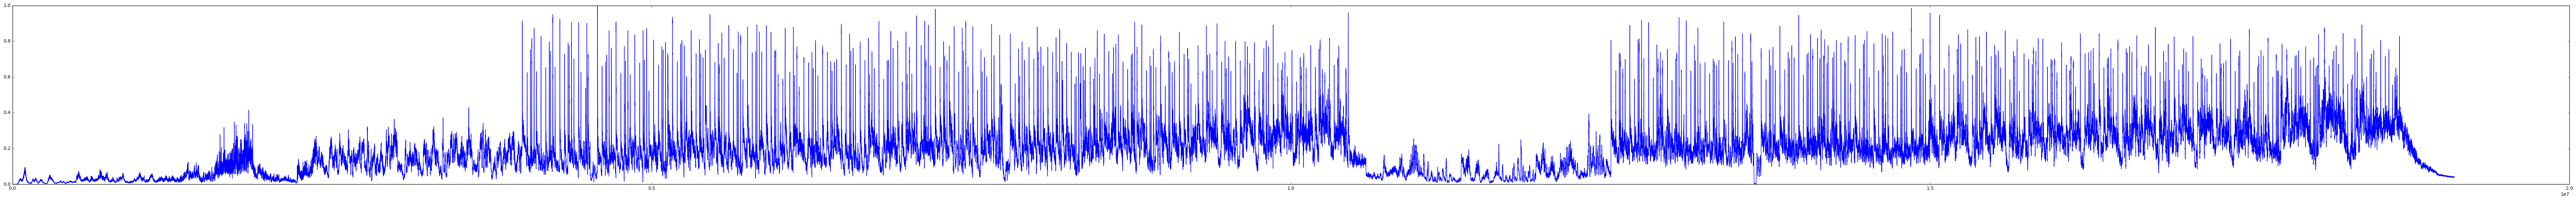

In [88]:
plt.figure(figsize=(100,7))
plt.plot(normalize(energy))

Calculate magnitude

In [89]:
def magnitude_func():
    sample = T.vector(dtype='int64')
    window_size = T.scalar(dtype = 'int16')
    
    sample_sq = np.abs(sample)
    padded_sample = T.concatenate([T.zeros([window_size]), sample_sq])
    cumsum = T.cumsum(padded_sample)
    magnitude = cumsum[window_size:] - cumsum[:-window_size]
    
    return theano.function([sample, window_size], magnitude)

In [90]:
magnitude = magnitude_func()

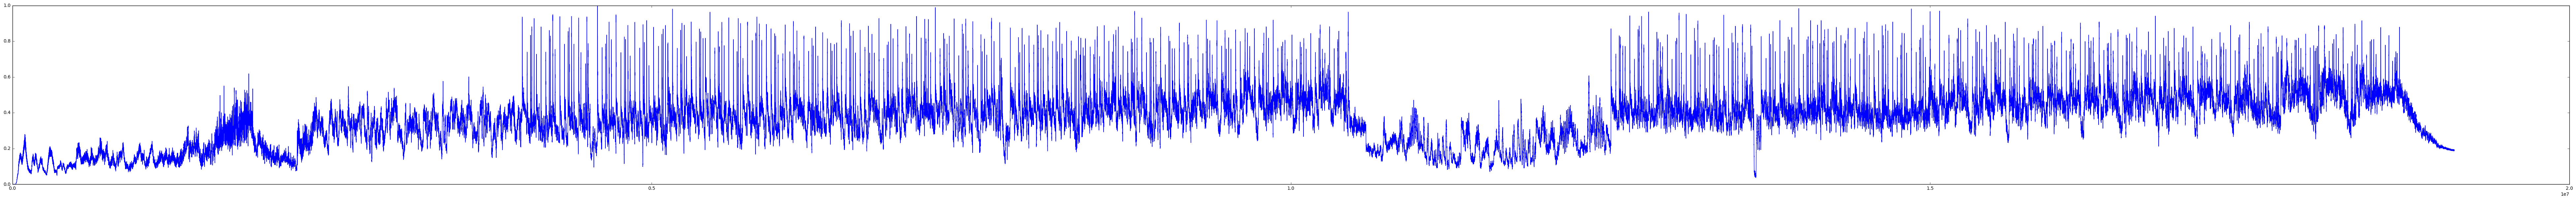

In [91]:
plt.figure(figsize=(100,7))
plt.plot(normalize(magnitude(sample, window_size_30)))

Zero crossing rate

In [92]:
def sign_func(number):
    return number >= 0

def zcr_func():
    sample = T.vector(dtype='float64')
    window_size = T.scalar(dtype = 'int16')
    
    a = sample[:sample.shape[0] - 1]
    b = sample[1:]
    
    a, updates = theano.scan(fn=sign_func, sequences=a)
    b, updates = theano.scan(fn=sign_func, sequences=b)
    
    sample_sq = np.abs(a - b)
    padded_sample = T.concatenate([T.zeros([window_size]), sample_sq])
    cumsum = T.cumsum(padded_sample)
    zcr = cumsum[window_size:] - cumsum[:-window_size]
    zcr = zcr / (2 * window_size)
    return theano.function([sample, window_size], zcr)

In [93]:
zcr = zcr_func()

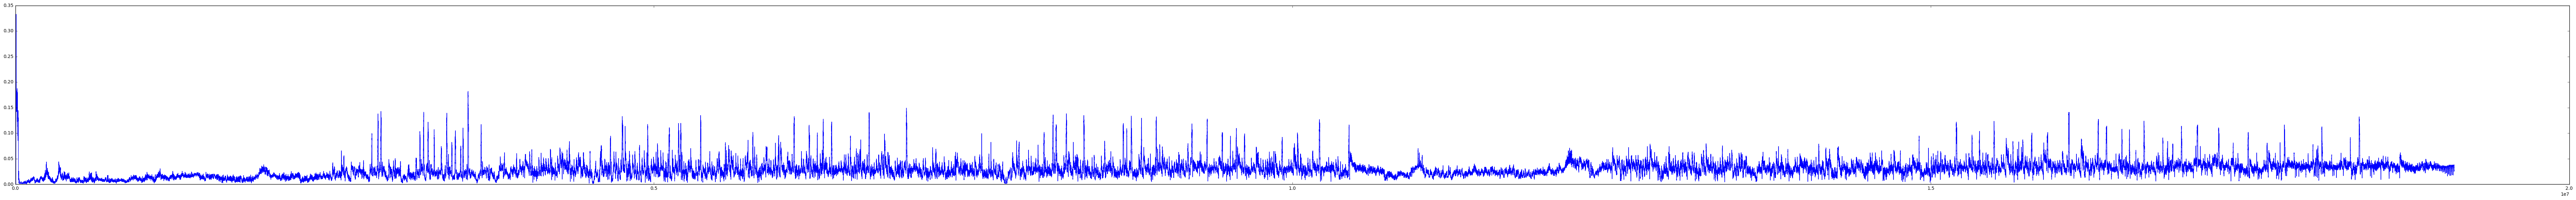

In [94]:
plt.figure(figsize=(100,7))
plt.plot(zcr(sample, window_size_30))

На одном графике

In [95]:
plt.figure(figsize=(100,7))

voice = plt.plot(normalize(sample))
zcr_line = plt.plot(normalize(zcr(sample, window_size_30)))
magnitude_line = plt.plot(normalize(magnitude(sample, window_size_30)))
energy_line = plt.plot(normalize(energy))

plt.legend(["Voice","Zero-Crossing rate", "Magnitude", "Energy"])
plt.xlabel("Time")

OverflowError: In draw_path: Exceeded cell block limit

In [99]:
energy_answer = [0.7 if i > 0.02 else -0.7 for i in normalize(get_energy(sample, window_size_30))]

In [100]:
plt.figure(figsize=(100,7))
plt.plot(normalize(sample))
plt.plot(energy_answer)

OverflowError: In draw_path: Exceeded cell block limit

In [7]:
def predict(signal, rate, window_size = 30, threshold = 0.3):
    '''
        :param signal: the array with signal
        :param rate: signal rate
        :param window_size_30: size of frame in ms
        :param threshold: threshold of prediction (from 0 to 1)
    '''
    
    window_size = int(window_size * (rate/1000))
    
    #zcr_answer = [True if i >  threshold else False for i in normalize(zcr(sample, window_size))]
    #magnitude_answer = [True if i > threshold else False for i in normalize(magnitude(sample, window_size))]
    energy_answer = [True if i >  threshold else False for i in normalize(get_energy(signal, window_size))]

    answer = {'energy': [],'magnitude': [], 'zcr': []}
    for a, b in zip(signal, energy_answer): #magnitude_answer, zcr_answer):
        if b:
            answer['energy'].append(a)
#         if c:
#             answer['magnitude'].append(a)
#         if d:
#             answer['zcr'].append(a)
    
    return answer

In [8]:
_all = predict(sample, sampling_rate, threshold=0.4)["energy"]

NameError: name 'normalize' is not defined

In [17]:
old = 0
_all = []
for i in tqdm_notebook(range(sampling_rate, len(sample) - sampling_rate, sampling_rate//10)):
    _all += (predict(sample[old:i], sampling_rate, threshold=0.9)["energy"])
    old = i

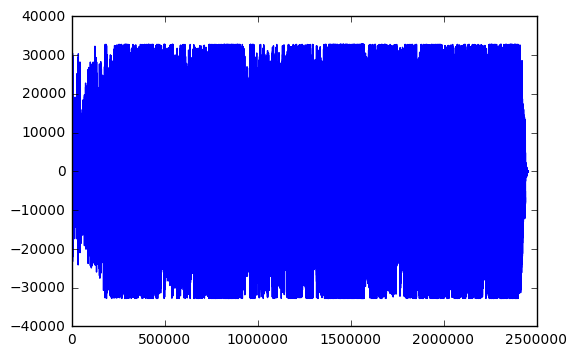

In [18]:
plt.plot(_all)

In [22]:
import scipy

In [23]:
scipy.io.wavfile.write('output.wav', sampling_rate, np.array(_all))